In [7]:
import numpy as np
from numpy import exp, log, log10, sqrt, zeros, ones, linspace
import matplotlib.pyplot as plt
import par
import modes
import spectra
import numba
import pickle

In [8]:
#@numba.njit
def square_basis(NC, theta):
    height = par.NT//NC
    width = par.NK//NC
    out = np.zeros((par.NK, par.NT))
    for i in range(NC**2):
        r,c = i//NC, i%NC
        out[r*width:(r+1)*width, c*height:(c+1)*height] = theta[i]
    out[:,A[::2] < par.a0_pca]=0
    return out

#@numba.njit
def get_square(n, val):
    height = par.NT//par.NC
    width = par.NK//par.NC
    out = np.zeros((par.NK, par.NT))
    r,c = n//par.NC, n%par.NC
    out[r*width:(r+1)*width, c*height:(c+1)*height] = val
    out[:,A[::2] < par.a0_pca]=0
    return out


In [9]:
H0 = 1.0
h = H0/100.
OmegaB0 = 0.04968
OmegaC0 = 0.26754
OmegaG0 = 5.50234e-5
OmegaN0 = 3.74248e-5 

NT = 2048
NK = par.NK
A = np.linspace(par.a0, par.a_rec, 2*NT)
K = np.linspace(0.01,1000,NK)

# 3 fluid GDM functions
wC = np.zeros(2*NT)
cs2C = np.zeros((2*NT,NK))
wN = np.ones(2*par.NT)*1/3
cs2N = np.ones((2*NT,NK))*1/3

# solve using 3-fluid
Y = modes.solve_3fld(A, K, wC, cs2C, wN, cs2N,
        OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)


In [10]:
# calculate GDM functions
Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC =Y[:, 3, :].T
vC = Y[:, 4, :].T
deltaN = Y[:, 5, :].T
vN =Y[:, 6, :].T

OmegaB = par.OmegaB0 * A[::2]**-3
OmegaC = par.OmegaC0 * A[::2]**-3
OmegaN = par.OmegaN0 * A[::2]**-4
OmegaG = par.OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC

wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN/3)/(deltaD*OmegaD)
delta_pD = deltaN

(0, 16000)

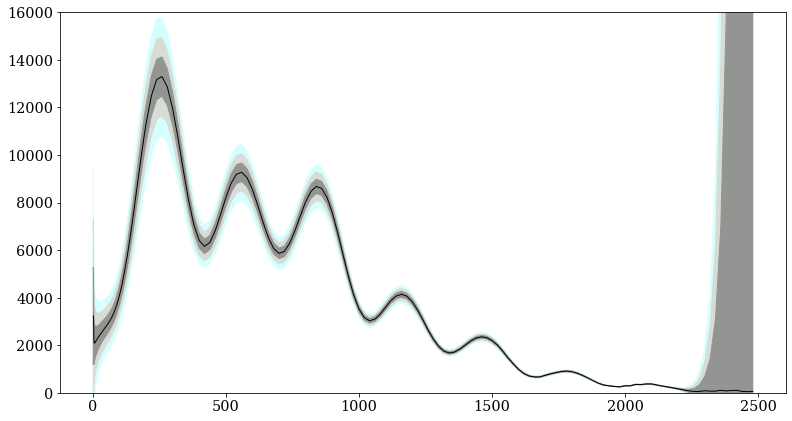

In [11]:
Cl = spectra.get_Cl_2fld(A[::2], K, wD, cs2D, deltaD[:,0], vD[:,0], 
                         OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)

Cl2 = spectra.get_Cl_2fld_p(A[::2], K, wD, delta_pD, deltaD[:,0], vD[:,0], 
                         OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)

ell = spectra.l_list
f_sky = 1.0  # fraction of sky
l_s = 480.  # filtering scale
theta_pix = 0.0012  # rad
sigma_pix = 16.e-6
wbar = 1/(0.33e-15)
B_cl = np.exp(-ell*(ell + 1)/l_s**2)

err = np.sqrt(
    (2/((2*ell+1)*f_sky)) * (Cl + wbar**(-1) * B_cl**-2)**2
)
Sigma = np.diag(err**2)

plt.rcParams.update(par.plot_params)

plt.fill_between(ell,Cl-3*err, Cl+3*err,
                 color='xkcd:very light blue')
plt.fill_between(ell,Cl-2*err, Cl+2*err,
                 color='xkcd:light gray')
plt.fill_between(ell,Cl-err, Cl+err,
                 color='xkcd:gray')
plt.plot(ell,Cl, color='black',linewidth=1)
plt.ylim(0,16000)


In [12]:
# pressure only pca
def DO_PCA(t):
    ss = 0.1**t #(derivative step size)
    J = np.zeros((spectra.L, par.NC**2+par.NC))

    print('computing derivatives (t='+str(t)+')')

    for n in range(par.NC**2):
        Delta_p = get_square(n, ss)
        Cl_fwd = spectra.get_Cl_2fld_p(A[::2], K, wD, delta_pD+Delta_p, 
                deltaD[:,0], vD[:,0], OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)
        Cl_bwd = spectra.get_Cl_2fld_p(A[::2], K, wD, delta_pD-Delta_p, 
                deltaD[:,0], vD[:,0], OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
        if(n % 10 == 0):
            print(str(n) + ' of ' + str(par.NC**2))
            
    pickle.dump(J, open("data/J_w_cs2_t"+str(t)+".p", "wb"))
    print('\n','derivatives saved (t='+str(t)+')')
    
    
    print('\n','computing Fisher matrix (t='+str(t)+')')
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("data/F_p_t"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (t='+str(t)+')')
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 
    print('\n','computing PCs (t='+str(t)+')')
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 
    PC = np.zeros((10, par.NK, par.NT))
    for i in range(10):
        PC[i,:,:] = square_basis(par.NC, PV[:,i])
    pickle.dump((PC), open("data/PC_p_t"+str(t)+".p", "wb"))
    print('\n','PCs matrix saved (t='+str(t)+')')


In [13]:
for i in range(5,8):
    DO_PCA(i)
    #DO_PCA(7)

computing derivatives (t=5)
0 of 16384
10 of 16384
20 of 16384
30 of 16384
40 of 16384
50 of 16384
60 of 16384
70 of 16384
80 of 16384
90 of 16384
100 of 16384
110 of 16384
120 of 16384
130 of 16384
140 of 16384
150 of 16384
160 of 16384
170 of 16384
180 of 16384
190 of 16384
200 of 16384
210 of 16384
220 of 16384
230 of 16384
240 of 16384
250 of 16384
260 of 16384
270 of 16384
280 of 16384
290 of 16384
300 of 16384
310 of 16384
320 of 16384
330 of 16384
340 of 16384
350 of 16384
360 of 16384
370 of 16384
380 of 16384
390 of 16384
400 of 16384
410 of 16384
420 of 16384
430 of 16384
440 of 16384
450 of 16384
460 of 16384
470 of 16384
480 of 16384
490 of 16384
500 of 16384
510 of 16384
520 of 16384
530 of 16384
540 of 16384
550 of 16384
560 of 16384
570 of 16384
580 of 16384
590 of 16384
600 of 16384
610 of 16384
620 of 16384
630 of 16384
640 of 16384
650 of 16384
660 of 16384
670 of 16384
680 of 16384
690 of 16384
700 of 16384
710 of 16384
720 of 16384
730 of 16384
740 of 16384
750 of 1

5920 of 16384
5930 of 16384
5940 of 16384
5950 of 16384
5960 of 16384
5970 of 16384
5980 of 16384
5990 of 16384
6000 of 16384
6010 of 16384
6020 of 16384
6030 of 16384
6040 of 16384
6050 of 16384
6060 of 16384
6070 of 16384
6080 of 16384
6090 of 16384
6100 of 16384
6110 of 16384
6120 of 16384
6130 of 16384
6140 of 16384
6150 of 16384
6160 of 16384
6170 of 16384
6180 of 16384
6190 of 16384
6200 of 16384
6210 of 16384
6220 of 16384
6230 of 16384
6240 of 16384
6250 of 16384
6260 of 16384
6270 of 16384
6280 of 16384
6290 of 16384
6300 of 16384
6310 of 16384
6320 of 16384
6330 of 16384
6340 of 16384
6350 of 16384
6360 of 16384
6370 of 16384
6380 of 16384
6390 of 16384
6400 of 16384
6410 of 16384
6420 of 16384
6430 of 16384
6440 of 16384
6450 of 16384
6460 of 16384
6470 of 16384
6480 of 16384
6490 of 16384
6500 of 16384
6510 of 16384
6520 of 16384
6530 of 16384
6540 of 16384
6550 of 16384
6560 of 16384
6570 of 16384
6580 of 16384
6590 of 16384
6600 of 16384
6610 of 16384
6620 of 16384
6630 o

11660 of 16384
11670 of 16384
11680 of 16384
11690 of 16384
11700 of 16384
11710 of 16384
11720 of 16384
11730 of 16384
11740 of 16384
11750 of 16384
11760 of 16384
11770 of 16384
11780 of 16384
11790 of 16384
11800 of 16384
11810 of 16384
11820 of 16384
11830 of 16384
11840 of 16384
11850 of 16384
11860 of 16384
11870 of 16384
11880 of 16384
11890 of 16384
11900 of 16384
11910 of 16384
11920 of 16384
11930 of 16384
11940 of 16384
11950 of 16384
11960 of 16384
11970 of 16384
11980 of 16384
11990 of 16384
12000 of 16384
12010 of 16384
12020 of 16384
12030 of 16384
12040 of 16384
12050 of 16384
12060 of 16384
12070 of 16384
12080 of 16384
12090 of 16384
12100 of 16384
12110 of 16384
12120 of 16384
12130 of 16384
12140 of 16384
12150 of 16384
12160 of 16384
12170 of 16384
12180 of 16384
12190 of 16384
12200 of 16384
12210 of 16384
12220 of 16384
12230 of 16384
12240 of 16384
12250 of 16384
12260 of 16384
12270 of 16384
12280 of 16384
12290 of 16384
12300 of 16384
12310 of 16384
12320 of 1

730 of 16384
740 of 16384
750 of 16384
760 of 16384
770 of 16384
780 of 16384
790 of 16384
800 of 16384
810 of 16384
820 of 16384
830 of 16384
840 of 16384
850 of 16384
860 of 16384
870 of 16384
880 of 16384
890 of 16384
900 of 16384
910 of 16384
920 of 16384
930 of 16384
940 of 16384
950 of 16384
960 of 16384
970 of 16384
980 of 16384
990 of 16384
1000 of 16384
1010 of 16384
1020 of 16384
1030 of 16384
1040 of 16384
1050 of 16384
1060 of 16384
1070 of 16384
1080 of 16384
1090 of 16384
1100 of 16384
1110 of 16384
1120 of 16384
1130 of 16384
1140 of 16384
1150 of 16384
1160 of 16384
1170 of 16384
1180 of 16384
1190 of 16384
1200 of 16384
1210 of 16384
1220 of 16384
1230 of 16384
1240 of 16384
1250 of 16384
1260 of 16384
1270 of 16384
1280 of 16384
1290 of 16384
1300 of 16384
1310 of 16384
1320 of 16384
1330 of 16384
1340 of 16384
1350 of 16384
1360 of 16384
1370 of 16384
1380 of 16384
1390 of 16384
1400 of 16384
1410 of 16384
1420 of 16384
1430 of 16384
1440 of 16384
1450 of 16384
1460 

6610 of 16384
6620 of 16384
6630 of 16384
6640 of 16384
6650 of 16384
6660 of 16384
6670 of 16384
6680 of 16384
6690 of 16384
6700 of 16384
6710 of 16384
6720 of 16384
6730 of 16384
6740 of 16384
6750 of 16384
6760 of 16384
6770 of 16384
6780 of 16384
6790 of 16384
6800 of 16384
6810 of 16384
6820 of 16384
6830 of 16384
6840 of 16384
6850 of 16384
6860 of 16384
6870 of 16384
6880 of 16384
6890 of 16384
6900 of 16384
6910 of 16384
6920 of 16384
6930 of 16384
6940 of 16384
6950 of 16384
6960 of 16384
6970 of 16384
6980 of 16384
6990 of 16384
7000 of 16384
7010 of 16384
7020 of 16384
7030 of 16384
7040 of 16384
7050 of 16384
7060 of 16384
7070 of 16384
7080 of 16384
7090 of 16384
7100 of 16384
7110 of 16384
7120 of 16384
7130 of 16384
7140 of 16384
7150 of 16384
7160 of 16384
7170 of 16384
7180 of 16384
7190 of 16384
7200 of 16384
7210 of 16384
7220 of 16384
7230 of 16384
7240 of 16384
7250 of 16384
7260 of 16384
7270 of 16384
7280 of 16384
7290 of 16384
7300 of 16384
7310 of 16384
7320 o

12300 of 16384
12310 of 16384
12320 of 16384
12330 of 16384
12340 of 16384
12350 of 16384
12360 of 16384
12370 of 16384
12380 of 16384
12390 of 16384
12400 of 16384
12410 of 16384
12420 of 16384
12430 of 16384
12440 of 16384
12450 of 16384
12460 of 16384
12470 of 16384
12480 of 16384
12490 of 16384
12500 of 16384
12510 of 16384
12520 of 16384
12530 of 16384
12540 of 16384
12550 of 16384
12560 of 16384
12570 of 16384
12580 of 16384
12590 of 16384
12600 of 16384
12610 of 16384
12620 of 16384
12630 of 16384
12640 of 16384
12650 of 16384
12660 of 16384
12670 of 16384
12680 of 16384
12690 of 16384
12700 of 16384
12710 of 16384
12720 of 16384
12730 of 16384
12740 of 16384
12750 of 16384
12760 of 16384
12770 of 16384
12780 of 16384
12790 of 16384
12800 of 16384
12810 of 16384
12820 of 16384
12830 of 16384
12840 of 16384
12850 of 16384
12860 of 16384
12870 of 16384
12880 of 16384
12890 of 16384
12900 of 16384
12910 of 16384
12920 of 16384
12930 of 16384
12940 of 16384
12950 of 16384
12960 of 1

1440 of 16384
1450 of 16384
1460 of 16384
1470 of 16384
1480 of 16384
1490 of 16384
1500 of 16384
1510 of 16384
1520 of 16384
1530 of 16384
1540 of 16384
1550 of 16384
1560 of 16384
1570 of 16384
1580 of 16384
1590 of 16384
1600 of 16384
1610 of 16384
1620 of 16384
1630 of 16384
1640 of 16384
1650 of 16384
1660 of 16384
1670 of 16384
1680 of 16384
1690 of 16384
1700 of 16384
1710 of 16384
1720 of 16384
1730 of 16384
1740 of 16384
1750 of 16384
1760 of 16384
1770 of 16384
1780 of 16384
1790 of 16384
1800 of 16384
1810 of 16384
1820 of 16384
1830 of 16384
1840 of 16384
1850 of 16384
1860 of 16384
1870 of 16384
1880 of 16384
1890 of 16384
1900 of 16384
1910 of 16384
1920 of 16384
1930 of 16384
1940 of 16384
1950 of 16384
1960 of 16384
1970 of 16384
1980 of 16384
1990 of 16384
2000 of 16384
2010 of 16384
2020 of 16384
2030 of 16384
2040 of 16384
2050 of 16384
2060 of 16384
2070 of 16384
2080 of 16384
2090 of 16384
2100 of 16384
2110 of 16384
2120 of 16384
2130 of 16384
2140 of 16384
2150 o

7300 of 16384
7310 of 16384
7320 of 16384
7330 of 16384
7340 of 16384
7350 of 16384
7360 of 16384
7370 of 16384
7380 of 16384
7390 of 16384
7400 of 16384
7410 of 16384
7420 of 16384
7430 of 16384
7440 of 16384
7450 of 16384
7460 of 16384
7470 of 16384
7480 of 16384
7490 of 16384
7500 of 16384
7510 of 16384
7520 of 16384
7530 of 16384
7540 of 16384
7550 of 16384
7560 of 16384
7570 of 16384
7580 of 16384
7590 of 16384
7600 of 16384
7610 of 16384
7620 of 16384
7630 of 16384
7640 of 16384
7650 of 16384
7660 of 16384
7670 of 16384
7680 of 16384
7690 of 16384
7700 of 16384
7710 of 16384
7720 of 16384
7730 of 16384
7740 of 16384
7750 of 16384
7760 of 16384
7770 of 16384
7780 of 16384
7790 of 16384
7800 of 16384
7810 of 16384
7820 of 16384
7830 of 16384
7840 of 16384
7850 of 16384
7860 of 16384
7870 of 16384
7880 of 16384
7890 of 16384
7900 of 16384
7910 of 16384
7920 of 16384
7930 of 16384
7940 of 16384
7950 of 16384
7960 of 16384
7970 of 16384
7980 of 16384
7990 of 16384
8000 of 16384
8010 o

12950 of 16384
12960 of 16384
12970 of 16384
12980 of 16384
12990 of 16384
13000 of 16384
13010 of 16384
13020 of 16384
13030 of 16384
13040 of 16384
13050 of 16384
13060 of 16384
13070 of 16384
13080 of 16384
13090 of 16384
13100 of 16384
13110 of 16384
13120 of 16384
13130 of 16384
13140 of 16384
13150 of 16384
13160 of 16384
13170 of 16384
13180 of 16384
13190 of 16384
13200 of 16384
13210 of 16384
13220 of 16384
13230 of 16384
13240 of 16384
13250 of 16384
13260 of 16384
13270 of 16384
13280 of 16384
13290 of 16384
13300 of 16384
13310 of 16384
13320 of 16384
13330 of 16384
13340 of 16384
13350 of 16384
13360 of 16384
13370 of 16384
13380 of 16384
13390 of 16384
13400 of 16384
13410 of 16384
13420 of 16384
13430 of 16384
13440 of 16384
13450 of 16384
13460 of 16384
13470 of 16384
13480 of 16384
13490 of 16384
13500 of 16384
13510 of 16384
13520 of 16384
13530 of 16384
13540 of 16384
13550 of 16384
13560 of 16384
13570 of 16384
13580 of 16384
13590 of 16384
13600 of 16384
13610 of 1

In [19]:
PC = pickle.load(open("data/PC_p_t7.p", "rb"))
F = pickle.load(open("data/F_p_t7.p", "rb"))
infl= square_basis(par.NC,np.diag(F))

C:\Users\Max Aifer\.conda\envs\quantum\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


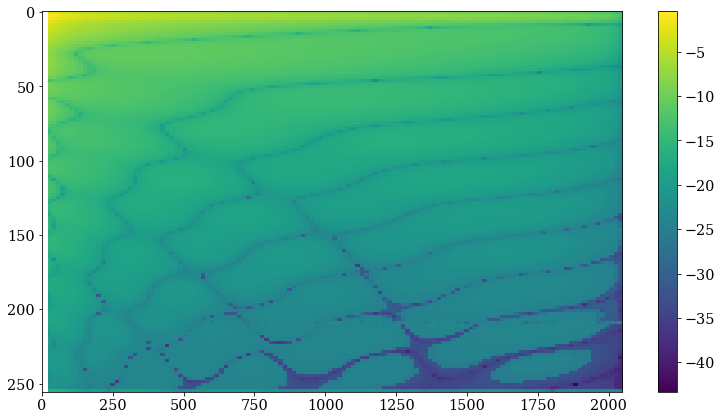

C:\Users\Max Aifer\.conda\envs\quantum\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


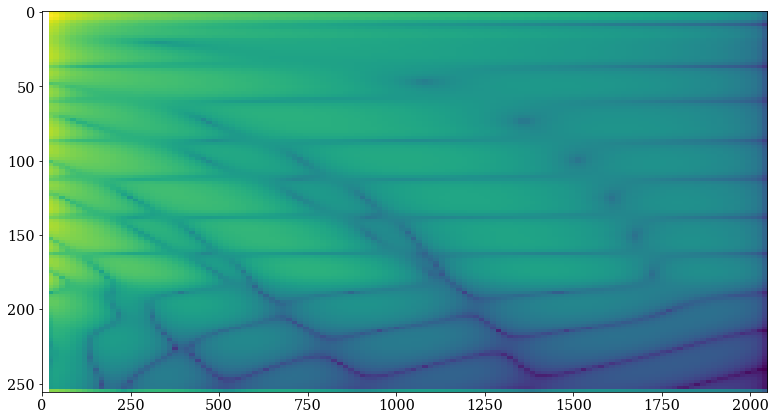

In [33]:
plt.imshow(np.log(np.abs(PC[0])),aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(log(infl),aspect='auto')

C:\Users\Max Aifer\.conda\envs\quantum\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


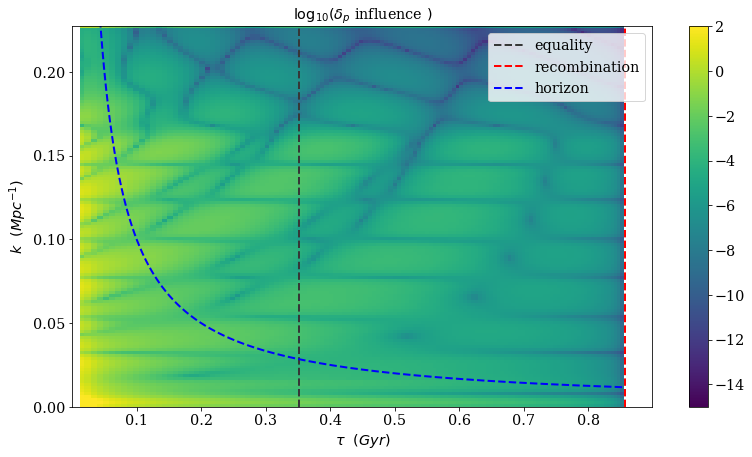

C:\Users\Max Aifer\.conda\envs\quantum\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


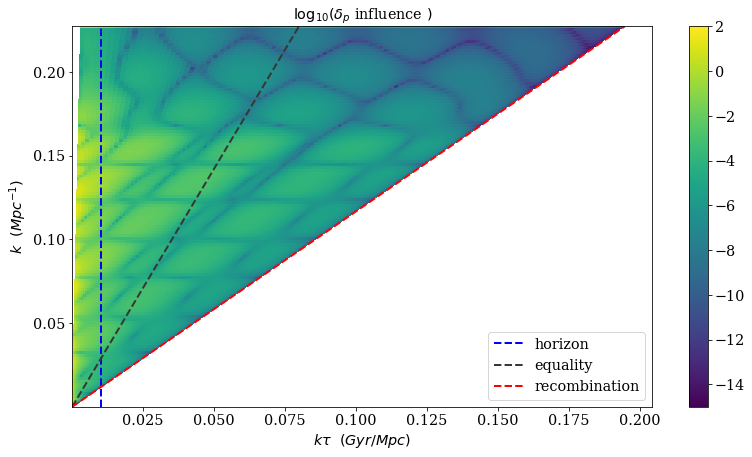

In [53]:
plt.title(r'$\log_{10}(\delta_p$ influence $)$')
plt.pcolor(TAU_Gyr[::2],K_Mpc, log10(abs(infl)),vmin = -15, vmax=2)
plt.colorbar()
plt.xlabel(r'$\tau$  $(Gyr)$')
plt.ylabel(r'$k$  $(Mpc^{-1})$')
plt.axvline(par.tau_eq*14, color='xkcd:dark gray', linewidth=2, linestyle='--')
plt.axvline(par.tau_rec*14, color='red', linewidth=2, linestyle='--')
plt.plot(TAU_Gyr, k_horizon/4400, color='blue', linewidth=2, linestyle='--')
plt.ylim(0, K_Mpc[-1])
plt.legend(['equality','recombination','horizon'])
plt.show()

plt.title(r'$\log_{10}(\delta_p$ influence $)$')
plt.pcolor(x,y, log10(abs(infl)),vmin = -15, vmax=2)
plt.colorbar()
plt.xlabel(r'$k \tau$  $(Gyr / Mpc)$')
plt.ylabel(r'$k$  $(Mpc^{-1})$')
plt.axvline(ktau_horizon, color='blue', linewidth=2, linestyle='--')
plt.plot(K_Mpc*par.tau_eq*14, K_Mpc, color='xkcd:dark gray', linewidth=2, linestyle='--')
plt.plot(K_Mpc*par.tau_rec*14, K_Mpc, color='red', linewidth=2, linestyle='--')
plt.legend(['horizon','equality','recombination'])
plt.show()

C:\Users\Max Aifer\.conda\envs\quantum\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


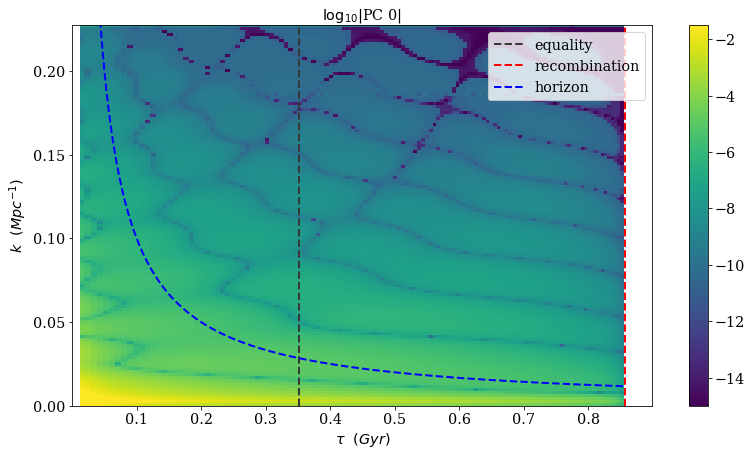

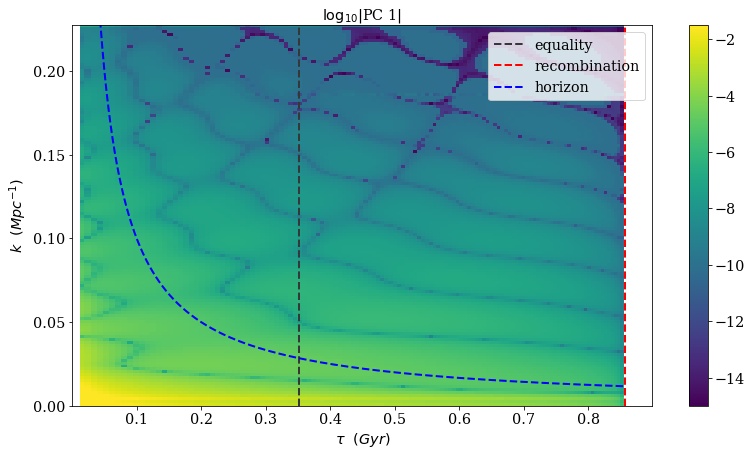

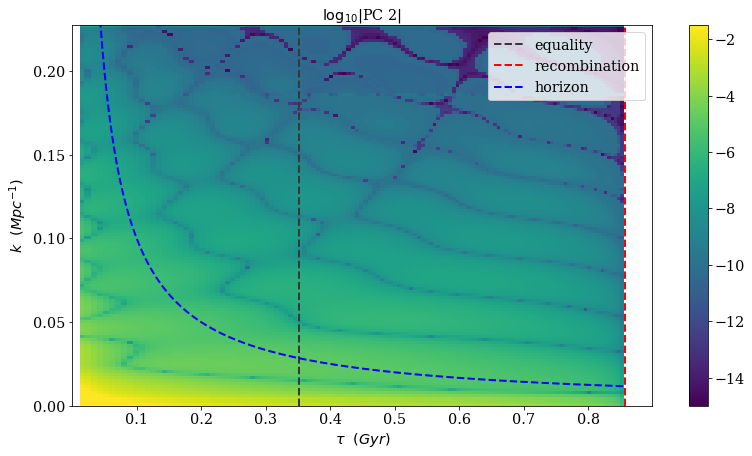

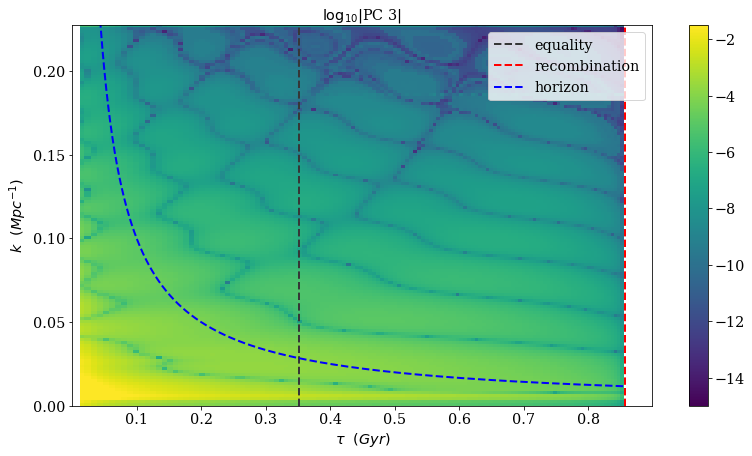

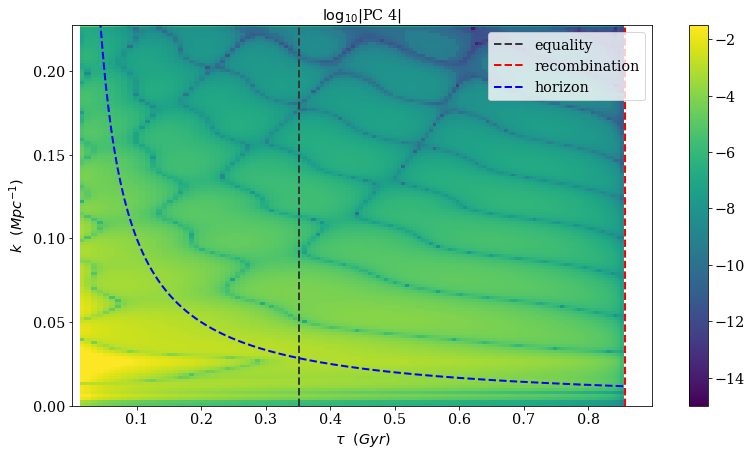

C:\Users\Max Aifer\.conda\envs\quantum\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


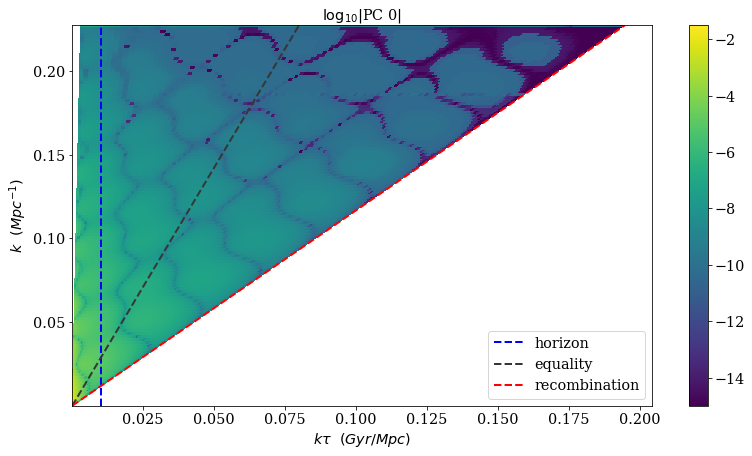

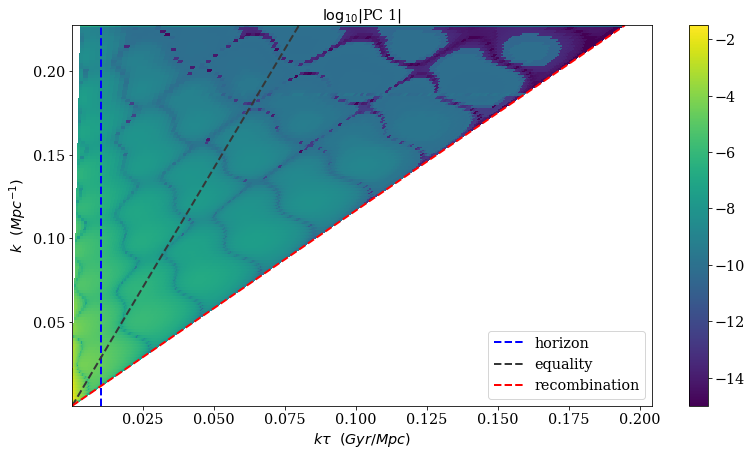

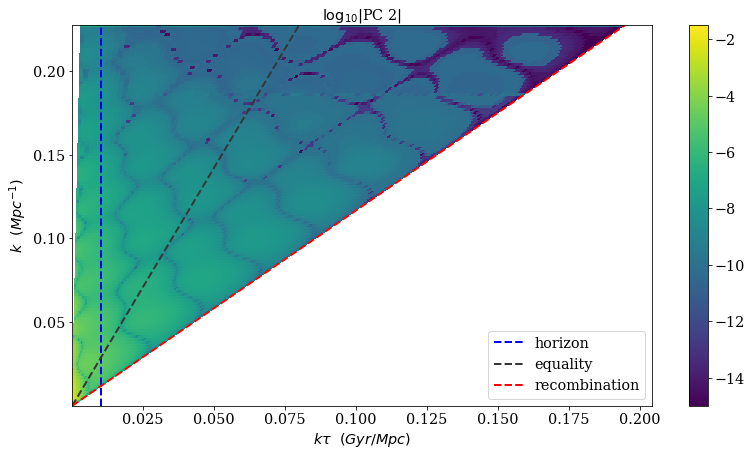

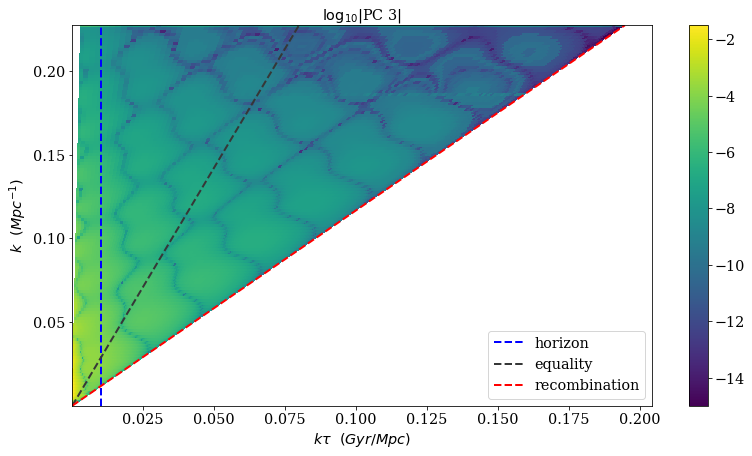

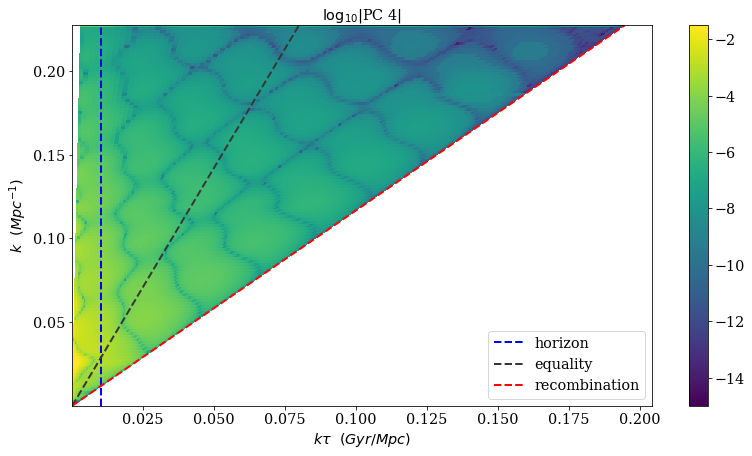

In [52]:
from numpy import log10
# compute horizon to plot horizon crossing:
H =  A * par.H0 * np.sqrt(par.OmegaM0*A**-3 + par.OmegaR0*A**-4 +  par.OmegaL0 ) 
TAU =  par.tau0 + modes.trapz(A, 1/(A * H))
k_horizon = np.pi/TAU
ktau_horizon = .01025# (one half wavelength inside horizon)
K_Mpc = K/4400
TAU_Gyr = 14*TAU
x = np.outer(K_Mpc,TAU_Gyr[::2])
y = np.outer(K_Mpc, np.ones(2048))

for n in range(5):

    plt.title(r'$\log_{10}|$PC ' +str(n)+'$|$')
    plt.pcolor(TAU_Gyr[::2],K_Mpc, log10(abs(PC[n])),vmin = -10, vmax=-1.5)
    plt.colorbar()
    plt.xlabel(r'$\tau$  $(Gyr)$')
    plt.ylabel(r'$k$  $(Mpc^{-1})$')
    plt.axvline(par.tau_eq*14, color='xkcd:dark gray', linewidth=2, linestyle='--')
    plt.axvline(par.tau_rec*14, color='red', linewidth=2, linestyle='--')
    plt.plot(TAU_Gyr, k_horizon/4400, color='blue', linewidth=2, linestyle='--')
    plt.ylim(0, K_Mpc[-1])
    plt.legend(['equality','recombination','horizon'])
    plt.show()
    
for n in range(5):
    plt.title(r'$\log_{10}|$PC ' +str(n)+'$|$')
    plt.pcolor(x,y, log10(abs(PC[n])),vmin = -15, vmax=-1.5)
    plt.colorbar()
    plt.xlabel(r'$k \tau$  $(Gyr / Mpc)$')
    plt.ylabel(r'$k$  $(Mpc^{-1})$')
    plt.axvline(ktau_horizon, color='blue', linewidth=2, linestyle='--')
    plt.plot(K_Mpc*par.tau_eq*14, K_Mpc, color='xkcd:dark gray', linewidth=2, linestyle='--')
    plt.plot(K_Mpc*par.tau_rec*14, K_Mpc, color='red', linewidth=2, linestyle='--')
    plt.legend(['horizon','equality','recombination'])
    plt.show()
